In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from libs import text
from postprocessing import similarity
from postprocessing import bias

# Setup

In [3]:
FACTUALITY_PATH = '../results/factuality'
APS_OA_DATA_TAR_GZ = '../../APS/data/final_dataset.tar.gz'
NOBEL_FN = '../data/organised_data/nobel_prize_with_openalex.json'
PLOTS_PATH = '../results/plots'

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_aps_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHOR_STATS_FN)
df_aps_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)
df_aps_stats.shape

(481012, 9)

In [6]:
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)
df_all_authors_stats = df_all_authors_stats.merge(df_aps_stats, on='id_author_oa', how='left')
df_all_authors_stats.shape

(481012, 38)

In [7]:
df_llm_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_author.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_llm_real_authors = df_llm_authors.copy()
df_llm_real_authors = df_llm_real_authors[['id_author_oa','clean_name','model','task_name','task_param','date','time']].merge(df_all_authors_stats, on='id_author_oa', how='left')
df_llm_real_authors.dropna(subset=['id_author_oa'], inplace=True)
df_llm_real_authors['task_name'] = io.pd.Categorical(df_llm_real_authors['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_llm_real_authors.shape

(108028, 44)

In [8]:
df_nobel_prize_winners = io.pd.DataFrame(io.read_json_file(NOBEL_FN))
df_nobel_prize_winners['decade'] = (df_nobel_prize_winners['year'] // 10) * 10
df_nobel_prize_winners['decade'] = df_nobel_prize_winners['decade'].apply(lambda x: str(int(x)))
df_nobel_prize_winners.shape

(1000, 9)

#  All responses

In [9]:
df_llm_real_authors.groupby('model').id_author_oa.nunique(), df_all_authors_stats.id_author_oa.nunique()

(model
 gemma2-9b          14
 llama-3.1-70b    1047
 llama-3.1-8b      150
 llama3-70b        550
 llama3-8b         288
 mixtral-8x7b      218
 Name: id_author_oa, dtype: int64,
 481012)

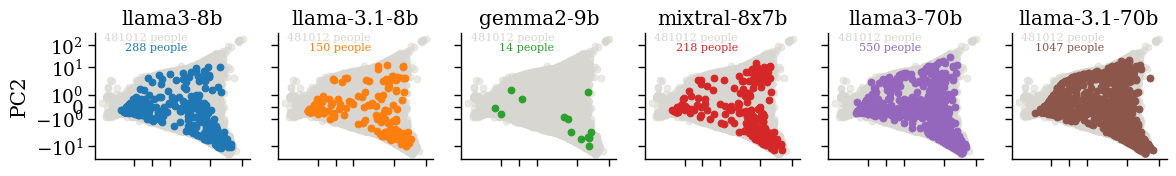

In [10]:
fn = io.path_join(PLOTS_PATH, 'components_by_model_all.pdf')
results = similarity.get_components_by_model(df_llm_real_authors, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL)
vis.plot_components_by_model_including_population(results, colors=constants.LLMS_COLORS,
                                                  col_order = constants.LLMS,
                                                  xlabel=None,
                                                  xticks=None,
                                                  fn=fn,
                                                  xscale='symlog',
                                                  yscale='symlog',
                                                  legend=False)

# Top-K

In [11]:
task_name = 'top_k'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param
gemma2-9b      top_5           3
llama-3.1-70b  top_100       520
               top_5          16
llama-3.1-8b   top_100        52
               top_5           4
llama3-70b     top_100       356
               top_5           5
llama3-8b      top_5           5
mixtral-8x7b   top_100        37
               top_5           4
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


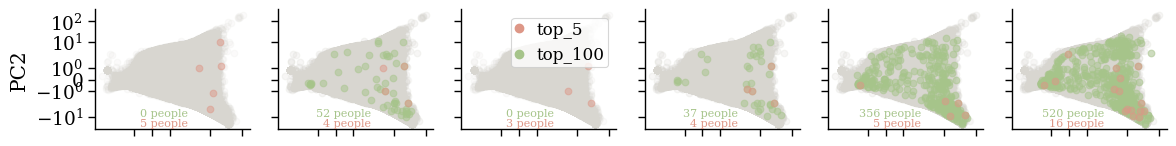

In [12]:
task_name = 'top_k'
categories = constants.TASK_TOPK_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

# Field

In [13]:
task_name = 'field'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param
gemma2-9b      PER             3
llama-3.1-70b  CM&MP         223
               PER            28
llama-3.1-8b   PER            17
llama3-70b     CM&MP          38
               PER            27
llama3-8b      CM&MP          37
               PER            12
mixtral-8x7b   CM&MP          20
               PER            22
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


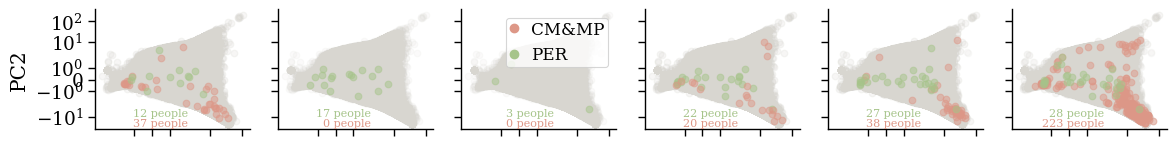

In [14]:
task_name = 'field'
categories = constants.TASK_FIELD_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

# Epoch

In [15]:
task_name = 'epoch'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param
gemma2-9b      1950s           9
llama-3.1-70b  1950s          56
               2000s         168
llama-3.1-8b   1950s          36
llama3-70b     1950s          17
               2000s          54
llama3-8b      1950s          11
mixtral-8x7b   1950s          18
               2000s           7
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


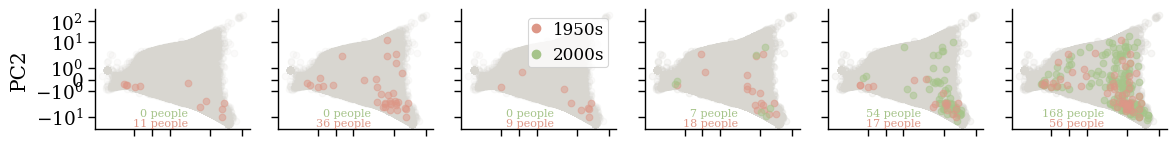

In [16]:
task_name = 'epoch'
categories = constants.TASK_EPOCH_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

# Seniority

In [17]:
task_name = 'seniority'
df_llm_real_authors.query("task_name==@task_name").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param  
llama-3.1-70b  early_career    104
               senior           58
llama-3.1-8b   early_career      6
llama3-70b     early_career      1
               senior          121
llama3-8b      early_career     47
               senior           41
mixtral-8x7b   early_career      2
               senior           10
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


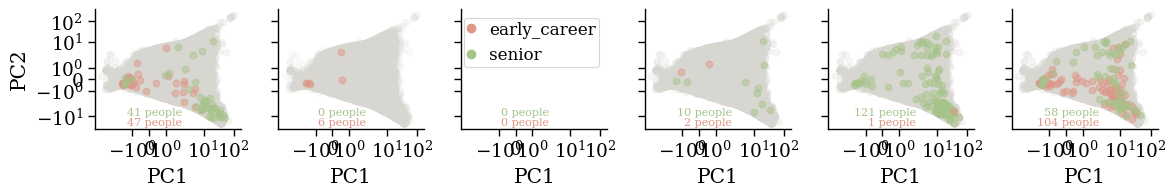

In [18]:
task_name = 'seniority'
categories = constants.TASK_SENIORITY_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  #xlabel=None,
                                                                  #xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

# Twins

## Famous

In [19]:
task_name = 'twins'
task_param = 'famous'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param   
llama-3.1-70b  famous_female    27
               famous_male      80
llama-3.1-8b   famous_female     5
               famous_male       7
llama3-70b     famous_female    20
               famous_male      24
llama3-8b      famous_female     3
               famous_male       5
mixtral-8x7b   famous_female     8
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


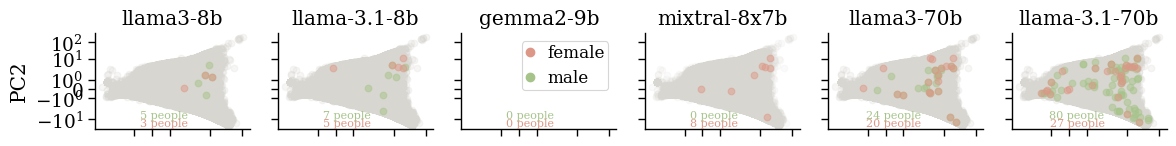

In [20]:
task_name = 'twins'
task_param = 'famous'
categories = constants.TASK_TWINS_FAMOUS_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  title=True,
                                                                  xlabel=None,
                                                                  xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

## Random

In [21]:
task_name = 'twins'
task_param = 'random'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param   
llama-3.1-70b  random_female    75
               random_male      57
llama-3.1-8b   random_male      17
llama3-70b     random_female    14
               random_male      19
llama3-8b      random_female     2
               random_male       9
mixtral-8x7b   random_female     2
               random_male      15
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


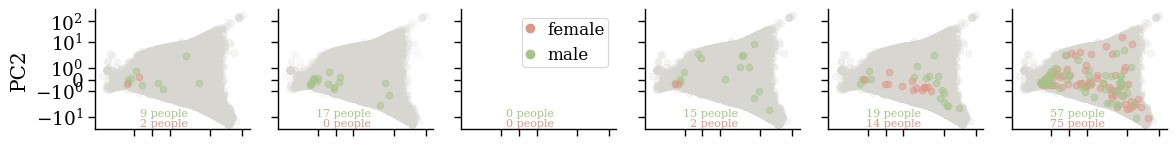

In [22]:
task_name = 'twins'
task_param = 'random'
categories = constants.TASK_TWINS_RANDOM_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

## Politician

In [23]:
task_name = 'twins'
task_param = 'politic'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param    
llama-3.1-70b  politic_female    15
               politic_male      35
llama-3.1-8b   politic_female     2
               politic_male       9
llama3-70b     politic_female    11
               politic_male       4
llama3-8b      politic_female    16
mixtral-8x7b   politic_female    16
               politic_male      17
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


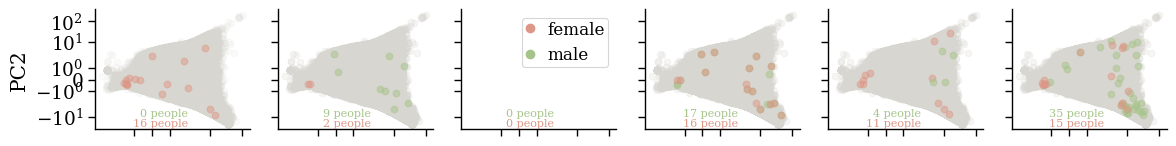

In [24]:
task_name = 'twins'
task_param = 'politic'
categories = constants.TASK_TWINS_POLITIC_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

## TV show

In [25]:
task_name = 'twins'
task_param = 'movie'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param  
llama-3.1-70b  movie_female    29
               movie_male      27
llama-3.1-8b   movie_male       9
llama3-70b     movie_female    16
               movie_male      12
llama3-8b      movie_male       9
mixtral-8x7b   movie_female    75
               movie_male      19
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


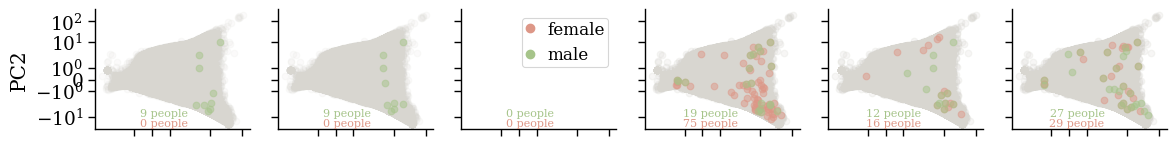

In [26]:
task_name = 'twins'
task_param = 'movie'
categories = constants.TASK_TWINS_MOVIE_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                  xlabel=None,
                                                                  xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

## Ficticious

In [27]:
task_name = 'twins'
task_param = 'fictitious'
df_llm_real_authors.query("task_name==@task_name and task_param.str.startswith(@task_param)").groupby(['model','task_param']).id_author_oa.nunique()

model          task_param       
llama-3.1-70b  fictitious_female    64
               fictitious_male      62
llama-3.1-8b   fictitious_female    11
               fictitious_male      26
llama3-70b     fictitious_female    26
               fictitious_male       8
llama3-8b      fictitious_female    46
               fictitious_male      63
mixtral-8x7b   fictitious_female    75
               fictitious_male       1
Name: id_author_oa, dtype: int64

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/postprocessing/similarity.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in df_sample_clean.groupby(groupby):


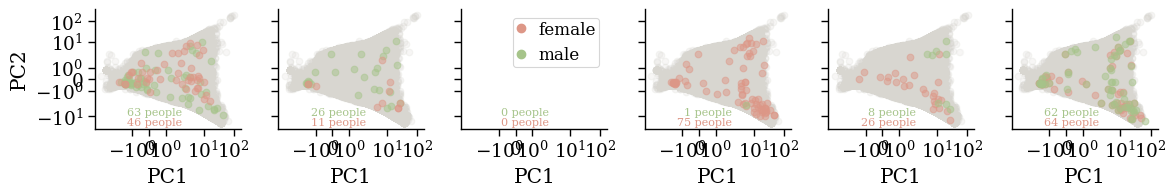

In [28]:
task_name = 'twins'
task_param = 'fictitious'
categories = constants.TASK_TWINS_FICTICIOUS_PARAMS

subset = df_llm_real_authors.query("task_name==@task_name and task_param in @categories").copy()
subset['task_param'] = io.pd.Categorical(subset['task_param'], categories=categories, ordered=True)
results = similarity.get_components_by_model(subset, df_all_authors_stats, 'APS', constants.ALL_SCHOLARLY_METRICS_COL, include_task_param=True)

fn = io.path_join(PLOTS_PATH, f'components_by_model_{task_name}_{task_param}.pdf')
vis.plot_components_by_model_and_param_value_including_population(results,
                                                                  col_order=constants.LLMS,
                                                                  hue_order=categories,
                                                                  fn=fn, 
                                                                #   xlabel=None,
                                                                #   xticks=None,
                                                                  xscale='symlog',
                                                                  yscale='symlog'
                                                                  )

___

# Nobel Prize winners

In [29]:
df_authors_nobel = bias.get_nobel_prize_stats(df_llm_real_authors, df_nobel_prize_winners)
df_authors_nobel.head(2)

,model,task_name,task_param,date,time,id_author_oa,clean_name,nobel_category,nobel_year,is_nobel,nobel_decade
0,llama3-8b,epoch,1950s,2024-12-09,00:00,5037710835.0,richard feynman,Physics,1965.0,True,1960
1,llama3-8b,epoch,1950s,2024-12-09,00:00,5088438810.0,julian schwinger,Physics,1965.0,True,1960


/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:303: FutureWarning: The default of observed=False is deprecated and will be changed to T

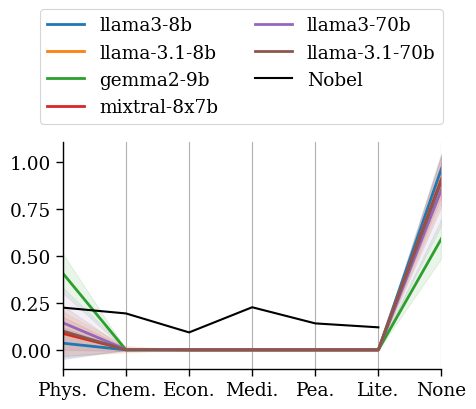

In [30]:
fname = 'nobel_laureates_by_category'
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

hue = 'model'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS
x_col = 'nobel_category'
x_order = constants.NOBEL_CATEGORIES
mean_col = 'mean'
std_col = 'std'

df_authors_nobel_stats, _ = bias.get_mean_percentages(df_authors_nobel, x_col, {x_col:x_order})
baselines, _ = bias.get_baselined_from_gt(df_nobel_prize_winners, 'category', x_order[:-1])

df_authors_nobel_stats_mean_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_authors_nobel_stats_std_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_authors_nobel_stats_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_authors_nobel_stats_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         baselines={'Nobel':{'values':baselines.drop(columns=['counts']).percentage}},
                         xticklabels_rename = constants.NOBEL_CATEGORIES_RENAME,
                         fn=fn
                         )

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:303: FutureWarning: The default of observed=False is deprecated and will be changed to T

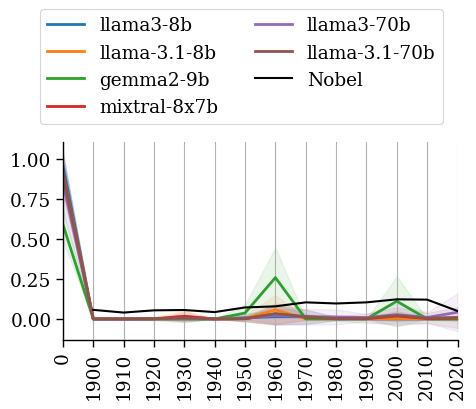

In [31]:
fname = 'nobel_laureates_by_year'
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

hue = 'model'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS
x_col = 'nobel_decade'
x_order = constants.NOBEL_DECADES
mean_col = 'mean'
std_col = 'std'

df_authors_nobel_stats, _ = bias.get_mean_percentages(df_authors_nobel, x_col, {x_col:x_order})
baselines, _ = bias.get_baselined_from_gt(df_nobel_prize_winners, 'decade', x_order)

df_authors_nobel_stats_mean_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_authors_nobel_stats_std_t = helpers.pivot_model_tasks(df_authors_nobel_stats, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_authors_nobel_stats_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_authors_nobel_stats_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         xlabel_rotation=90,
                         baselines={'Nobel':{'values':baselines.drop(columns=['counts']).percentage}},
                         fn=fn
                         )

___

# Rankings

In [32]:
df_ranking_rec_stats = df_llm_real_authors.copy() 
df_ranking_rec_stats.drop_duplicates(subset=['model','id_author_oa'], inplace=True)
df_ranking_rec_stats.shape

(2267, 44)

In [33]:
df_ranking_rec_stats.loc[:,'aps_citations_per_paper_age'] = df_ranking_rec_stats.loc[:,'aps_cited_by_count'] / df_ranking_rec_stats.loc[:,'aps_works_count'] / df_ranking_rec_stats.loc[:,'aps_career_age']  
df_all_authors_stats.loc[:,'aps_citations_per_paper_age'] = df_all_authors_stats.loc[:,'aps_cited_by_count'] / df_all_authors_stats.loc[:,'aps_works_count'] / df_all_authors_stats.loc[:,'aps_career_age']  

## Works count (number of publications)

aps_works_count


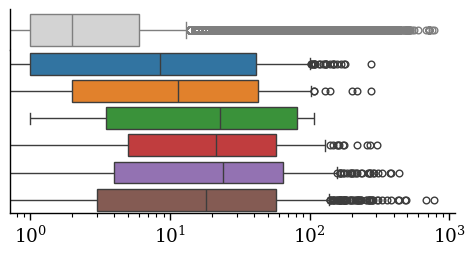

In [34]:
metric = 'aps_works_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                   )

works_count


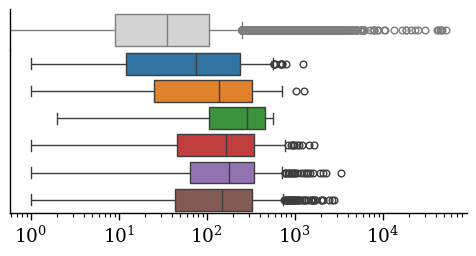

In [35]:
metric = 'works_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## Citations

aps_cited_by_count


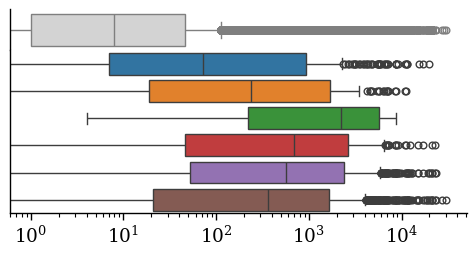

In [36]:
metric = 'aps_cited_by_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

cited_by_count


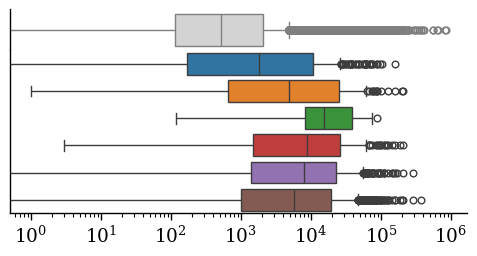

In [37]:
metric = 'cited_by_count'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## h-index

aps_h_index


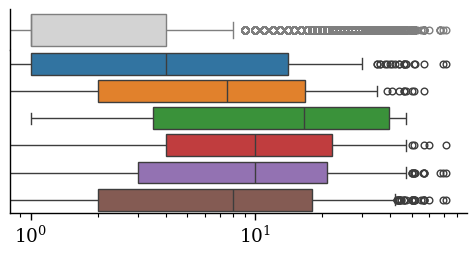

In [38]:
metric = 'aps_h_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

h_index


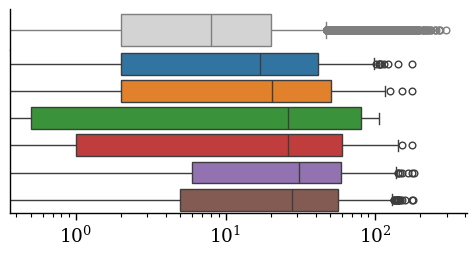

In [39]:
metric = 'h_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## i10-index

aps_i10_index


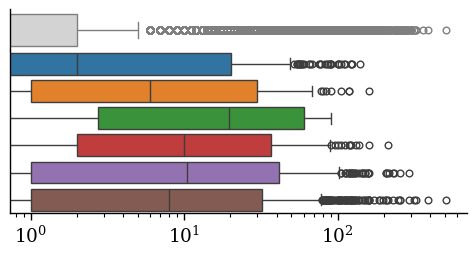

In [40]:
metric = 'aps_i10_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

i10_index


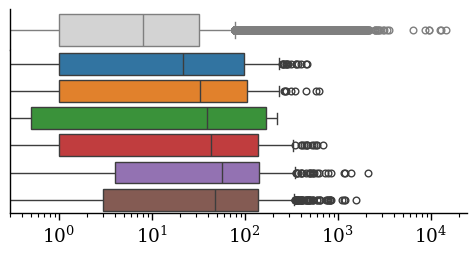

In [41]:
metric = 'i10_index'
print(metric)
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## E-index

aps_e_index


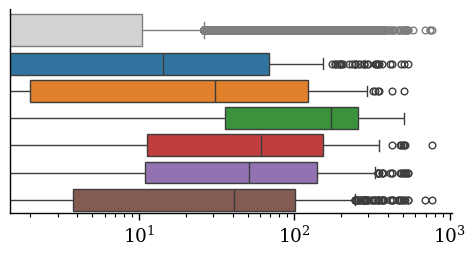

In [42]:
metric = 'aps_e_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

e_index


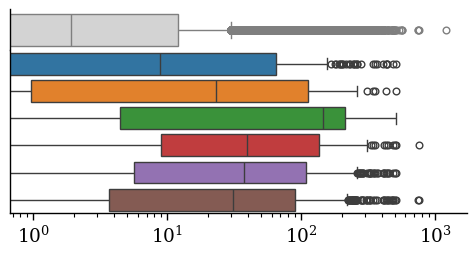

In [43]:
metric = 'e_index'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## Career age

aps_career_age


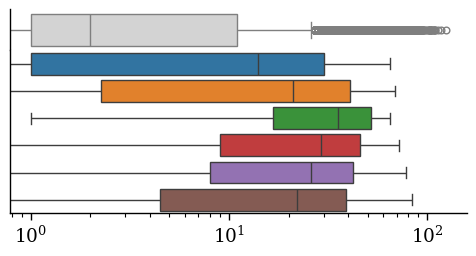

In [44]:
metric = 'aps_career_age'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

career_age


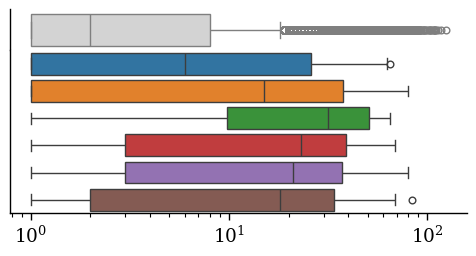

In [45]:
metric = 'career_age'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

## Others
e-index, normalized citation counts, and 2year_mean_citations

aps_citations_per_paper_age


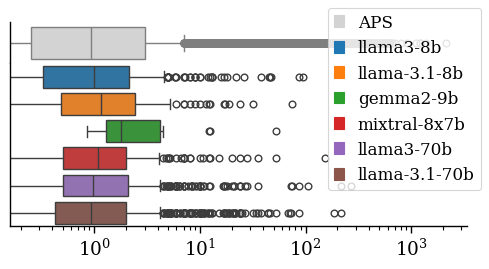

In [46]:
metric = 'aps_citations_per_paper_age'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=True, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )

two_year_mean_citedness


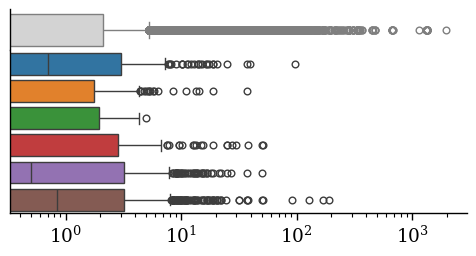

In [47]:
metric = 'two_year_mean_citedness'
print(metric)
fn = io.path_join(PLOTS_PATH, f'popularity_{metric}.pdf')
vis.plot_error_box_plot_comparison(df_ranking_rec_stats, df_all_authors_stats, 
                                   legend=False, yticks=False,
                                   figsize=constants.PLOT_FIGSIZE_NARROW,
                                   metric=metric, 
                                   fn=fn
                                )